Bevi Data Science Co-op Forecasting Exercise
The goal of this exercise is to understand your approach to building an ML model in Python. The following are the aspects that we will be looking at.
● Data Handling and assumptions
● Feature Engineering
● Model Selection
● Accuracy Checks
● Inferences
● Next Steps

Exercise:
- We’ve given you weekly dispense data for six of our machines before October 2023. You need to use this data to create a forecasted weekly total usage for the weeks in months July to November.

- Your forecasts should be based on data till the end of June 2023. The data provided for July 23 to September 23 is only for testing purposes.
Week: 
- Our week starts on Monday and ends on Sunday. The weekend dates you see in the data represent the date a week ended with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_excel('co-op dataset.xlsx')

In [3]:
missing_values = data.isna().sum()
print(missing_values)

ID                     0
WEEK_END_DT            0
TOTAL_DISPENSED       43
FLAVORED_DISPENSED    43
dtype: int64


In [4]:
data.head()

,ID,WEEK_END_DT,TOTAL_DISPENSED,FLAVORED_DISPENSED
0,743BD6E,2022-07-10,278418.0,60878.00000
1,1CD19D3,2022-07-10,28045.0,10517.00004
2,D3635AD,2022-07-10,23631.0,16203.99998
3,A74A256,2022-07-10,NaN,NaN
4,BB7EA2A,2022-07-10,132980.0,79995.00001


In [5]:
missing_values_by_id = data.groupby('ID')[['TOTAL_DISPENSED', 'FLAVORED_DISPENSED']].apply(lambda x: x.isnull().sum())
print(missing_values_by_id)

         TOTAL_DISPENSED  FLAVORED_DISPENSED
ID                                          
1CD19D3               34                  34
743BD6E                5                   5
A74A256                4                   4
BB7EA2A                0                   0
D3635AD                0                   0
FBCE7D2                0                   0


In [6]:
def seasonal_interpolation(data):
    # Convert 'WEEK_END_DT' column to datetime format
    data['WEEK_END_DT'] = pd.to_datetime(data['WEEK_END_DT'])
    
    # Group the data by 'ID'
    grouped_data = data.groupby('ID')
    
    # Perform seasonal interpolation for each group
    interpolated_data = grouped_data.apply(lambda x: interpolate_zeros(x))
    
    # Reset the index of the interpolated data
    interpolated_data.reset_index(drop=True, inplace=True)
    
    # Merge the 'ID' column back to the interpolated data
    interpolated_data = interpolated_data.merge(data[['ID']], left_index=True, right_index=True)
    
    return interpolated_data

def interpolate_zeros(group):
    # Replace 0 values with NaN
    group.replace(0, np.nan, inplace=True)
    
    # Forward fill NaN values
    group.fillna(method='ffill', inplace=True)
    
    # Backward fill NaN values
    group.fillna(method='bfill', inplace=True)
    
    # Calculate the average of non-zero values
    non_zero_avg = group[group != 0].mean()
    
    # Replace continuous 0 values with the average
    group = group.replace(0, non_zero_avg)
    
    return group

# Call the seasonal_interpolation function
interpolated_data = seasonal_interpolation(data)
interpolated_data.reset_index(drop=True, inplace=True)
data = interpolated_data
print(data)

    WEEK_END_DT  TOTAL_DISPENSED  FLAVORED_DISPENSED       ID
0    2022-07-10          28045.0         10517.00004  743BD6E
1    2022-07-17          34723.0         12025.99998  1CD19D3
2    2022-07-24          33345.0         13743.00000  D3635AD
3    2022-07-31          41009.0         17136.00000  A74A256
4    2022-08-07          24561.0          6542.99999  BB7EA2A
..          ...              ...                 ...      ...
350  2023-09-03          19166.0          3515.00001  FBCE7D2
351  2023-09-10          12876.0          5238.00001  1CD19D3
352  2023-09-17          19485.0          7958.00000  D3635AD
353  2023-09-24          21427.0          7323.99999  A74A256
354  2023-10-01          18096.0          6573.00001  BB7EA2A

[355 rows x 4 columns]


/var/folders/1g/0mj97r555d15d54dx2257j7m0000gn/T/ipykernel_10874/1107381518.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group.fillna(method='ffill', inplace=True)
/var/folders/1g/0mj97r555d15d54dx2257j7m0000gn/T/ipykernel_10874/1107381518.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group.fillna(method='bfill', inplace=True)
/var/folders/1g/0mj97r555d15d54dx2257j7m0000gn/T/ipykernel_10874/1107381518.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group.fillna(method='ffill', inplace=True)
/var/folders/1g/0mj97r555d15d54dx2257j7m0000gn/T/ipykernel_10874/1107381518.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill(

In [7]:
data

,WEEK_END_DT,TOTAL_DISPENSED,FLAVORED_DISPENSED,ID
0,2022-07-10,28045.0,10517.00004,743BD6E
1,2022-07-17,34723.0,12025.99998,1CD19D3
2,2022-07-24,33345.0,13743.00000,D3635AD
3,2022-07-31,41009.0,17136.00000,A74A256
4,2022-08-07,24561.0,6542.99999,BB7EA2A
...,...,...,...,...
350,2023-09-03,19166.0,3515.00001,FBCE7D2
351,2023-09-10,12876.0,5238.00001,1CD19D3
352,2023-09-17,19485.0,7958.00000,D3635AD
353,2023-09-24,21427.0,7323.99999,A74A256


In [8]:
zero_counts = data[data['TOTAL_DISPENSED'] == 0].groupby('ID').size()
distinct_zero_counts = zero_counts[zero_counts > 0].reset_index()
distinct_zero_counts.columns = ['ID', 'TOTAL_DISPENSED_zero_count']

zero_counts = data[data['FLAVORED_DISPENSED'] == 0].groupby('ID').size()
distinct_zero_counts['FLAVORED_DISPENSED_zero_count'] = zero_counts[zero_counts > 0].reset_index()[0]

distinct_zero_counts

,ID,TOTAL_DISPENSED_zero_count,FLAVORED_DISPENSED_zero_count


In [9]:
data.head()

,WEEK_END_DT,TOTAL_DISPENSED,FLAVORED_DISPENSED,ID
0,2022-07-10,28045.0,10517.00004,743BD6E
1,2022-07-17,34723.0,12025.99998,1CD19D3
2,2022-07-24,33345.0,13743.00000,D3635AD
3,2022-07-31,41009.0,17136.00000,A74A256
4,2022-08-07,24561.0,6542.99999,BB7EA2A


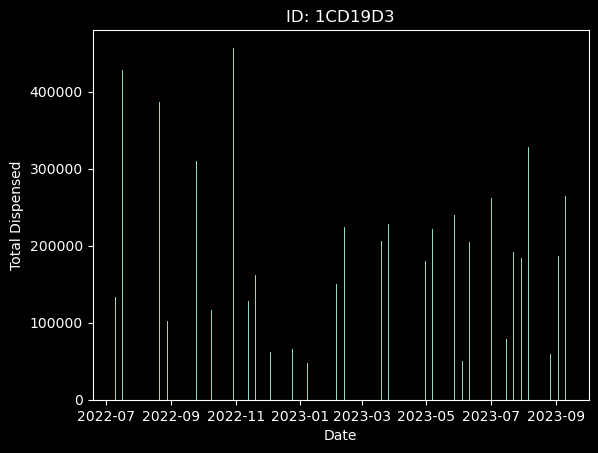

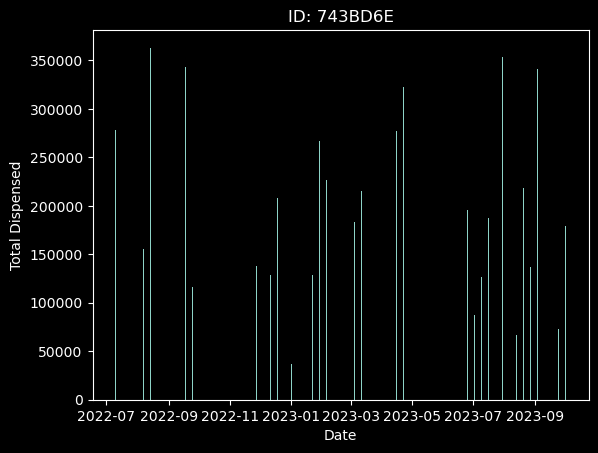

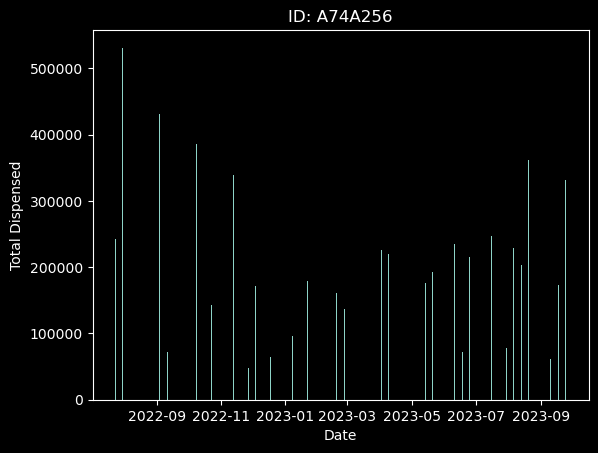

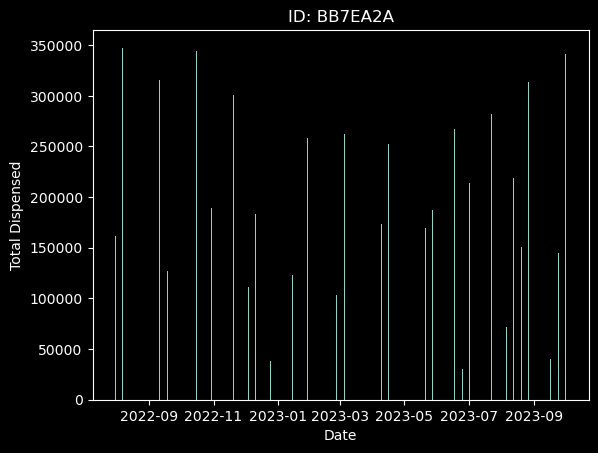

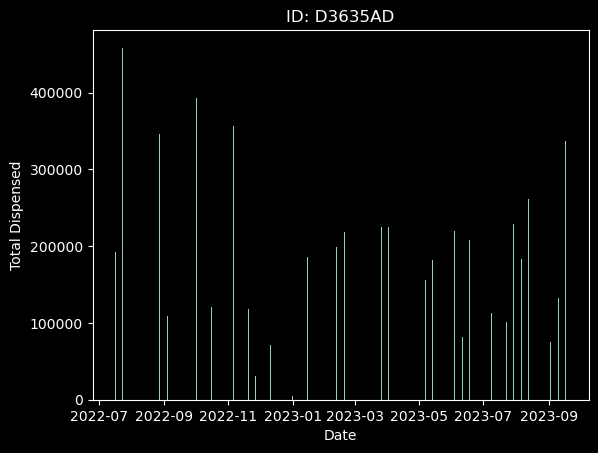

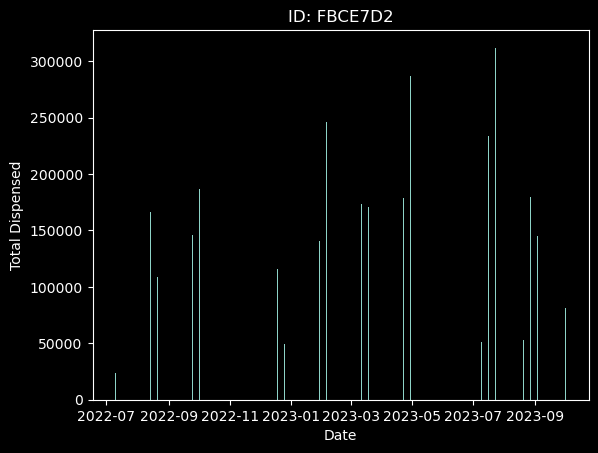

In [13]:
import matplotlib.pyplot as plt

# Group the data by ID
grouped_data = data.groupby('ID')

# Plot each group separately
for group_name, group_data in grouped_data:
    plt.figure()
    plt.bar(group_data['WEEK_END_DT'], group_data['TOTAL_DISPENSED'])
    plt.xlabel('Date')
    plt.ylabel('Total Dispensed')
    plt.title(f'ID: {group_name}')
    plt.show()

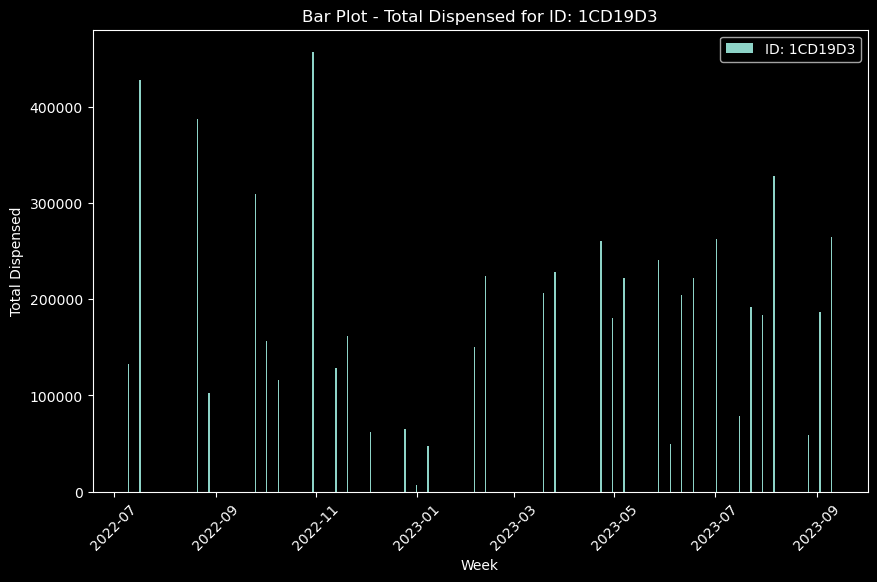

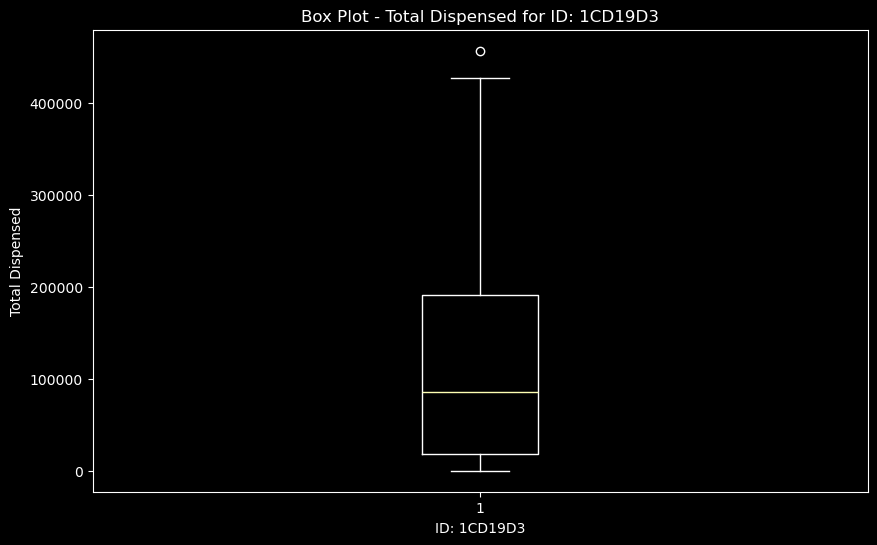

In [17]:
import matplotlib.pyplot as plt

# Filter data for each ID
id_1_data = data[data['ID'] == '1CD19D3']
id_2_data = data[data['ID'] == '743BD6E']
id_3_data = data[data['ID'] == 'A74A256']

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(id_1_data['WEEK_END_DT'], id_1_data['TOTAL_DISPENSED'], label='ID: 1CD19D3')
plt.xlabel('Week')
plt.ylabel('Total Dispensed')
plt.title('Bar Plot - Total Dispensed for ID: 1CD19D3')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(id_1_data['TOTAL_DISPENSED'])
plt.xlabel('ID: 1CD19D3')
plt.ylabel('Total Dispensed')
plt.title('Box Plot - Total Dispensed for ID: 1CD19D3')
plt.show()



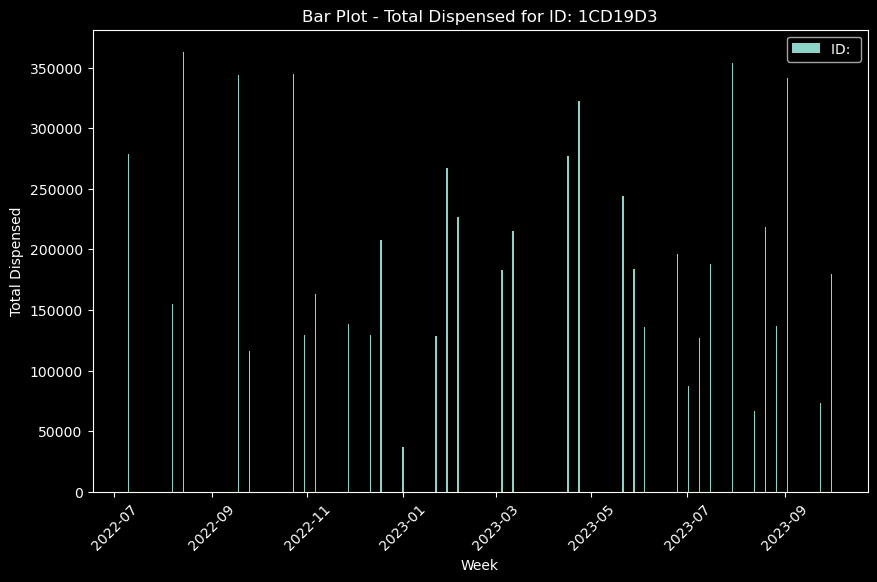

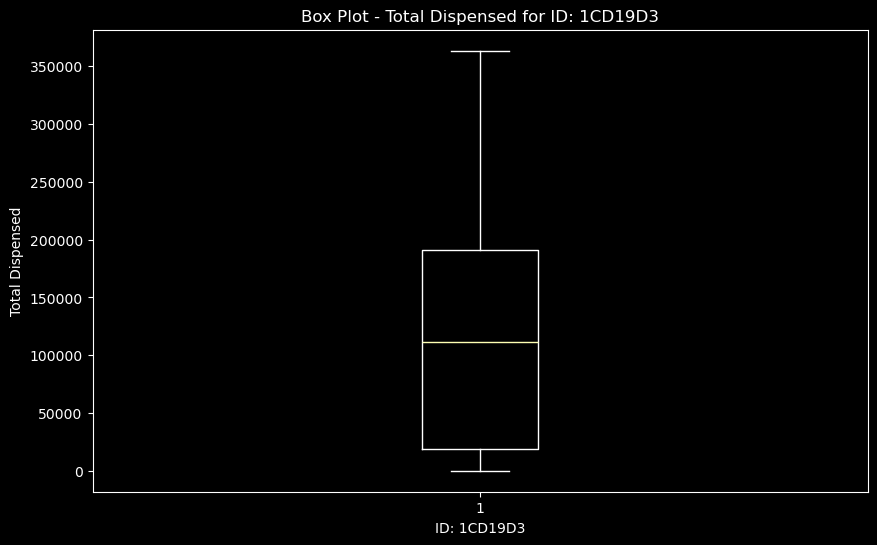

In [18]:
# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(id_2_data['WEEK_END_DT'], id_2_data['TOTAL_DISPENSED'], label='ID: ')
plt.xlabel('Week')
plt.ylabel('Total Dispensed')
plt.title('Bar Plot - Total Dispensed for ID: 1CD19D3')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(id_2_data['TOTAL_DISPENSED'])
plt.xlabel('ID: 1CD19D3')
plt.ylabel('Total Dispensed')
plt.title('Box Plot - Total Dispensed for ID: 1CD19D3')
plt.show()
